#اضافه کردن کتابخانه های مورد نیاز

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split

#استفاده از مدل Bert در هاگینگفیس
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer

import torch
from torch.utils.data import Dataset , DataLoader
from torch.optim import Adam

In [ ]:
print(f"pythorch version: {torch.__version__}")

pythorch version: 2.5.1+cu121


#خواندن دیتاست اسنپ فود

In [ ]:
train_data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Snapfood/train.csv',
                  encoding='utf8',on_bad_lines='skip',delimiter=',',index_col=False)
#encoding=چون زبان فارسیه و انکدینگ مناسب زبان فارسی یوتی‌اف هشت
#delimiter=جدا کننده سوتون ها با , هست توی دیتاست
#on bad line=خط بد ینی خطی که بد باشه رو ازش بگذره
#index_col=دیگه خودش ایندکس نده بهش
#usecols=میگیم که چندتا سوتون رو میخاییم use cloumns


جدا کردن 1000 رکورد داده

In [ ]:
train_data= train_data[:1000]

train_data

,comment,label,label_id
0,غذا خیلی سرد بود در صورتیکه فاصله ما خیلی کم است,SAD,1.0
1,بهتره بتونیم ران یا سینه رو خودمون انتخاب کنیم,HAPPY,0.0
2,غذا بد بود حالم خیییییلی بده. دل دردو دل پیچه....,SAD,1.0
3,با سلام سابق بر این بسته بندی از کیفیت بهتری ب...,SAD,1.0
4,سلام، خیلی ممنون و متشکرم,HAPPY,0.0
...,...,...,...
995,مرغ ساندویچ خام بود و این خیلی بده,SAD,1.0
996,ساندویچ خیلی شور بود,SAD,1.0
997,اصلا راضی نبودم! تن ماهی رژیمی سفارش دادم و تن...,SAD,1.0
998,بستنی معجون مگه چاییه؟! پر از هل و دارچین بود ...,SAD,1.0


#گرفتن امار بر حسب کلاس های مختلف

اگر کلاس هامون بالانس باشن تعدادشون این توی اموزش خوبه ولی اگر تعدادش انبالانس باشه ینی متعادل نباشه این باعث کاهش دقت مدل میشه ولی یکسری الگوریتم هم مبتنی بر اینبالانس دیتاست هست که باید بخونیم

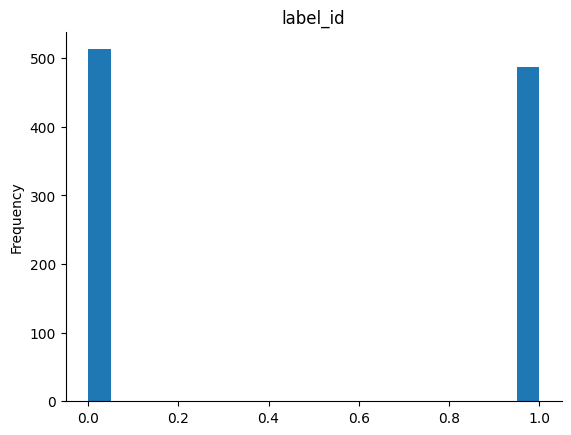

In [ ]:
import matplotlib.pyplot as plt


train_data['label_id'].plot(kind='hist',bins=20)
plt.title('label_id')
plt.gca().spines[['top','right',]].set_visible(False)

#خواندن داده اعتبار سنجی (validation)

In [ ]:
val_data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Snapfood/validation.csv',
                     encoding='utf8',on_bad_lines='skip',
                     delimiter=',',index_col=False)


جدا کردن 100 رکورد داده

In [ ]:
val_data=val_data[:100]

val_data

,comment,label,label_id
0,درسته که توی فودپارتی راضی شدید تخفیف بیشتری ب...,SAD,1.0
1,سلام تخم مرغ را برندی دیگه فرستادن قرار شدن عو...,SAD,1.0
2,مثل همیشه عالی و خوشمزه، خیلی هم سریع رسید. ممنون,HAPPY,0.0
3,پیتزا سرد بود ساندویچ عالی بود ممنون,HAPPY,0.0
4,من بندری بزرگ سفارش داده بودم ولی برام ساندویچ...,SAD,1.0
...,...,...,...
95,ماست موسیر سفارش دادم مبلغش هم حساب شد ولی ارس...,SAD,1.0
96,کیفیت بسیار معمولی و متوسط و فقط شکم پر کن,SAD,1.0
97,با سلام خدمت مدیر غذا بسیار بسیار بی کیفیت و س...,SAD,1.0
98,گوجه فرنگی گلخانه‌ای و سفید به جای گوجه فرنگی ...,HAPPY,0.0


در پایان هر ایپاک(تکرار) که مدل رو با داده ترین اموزش دادیم با داده ولیدیشن ارزیابی میکنیم

امار کلاس ها

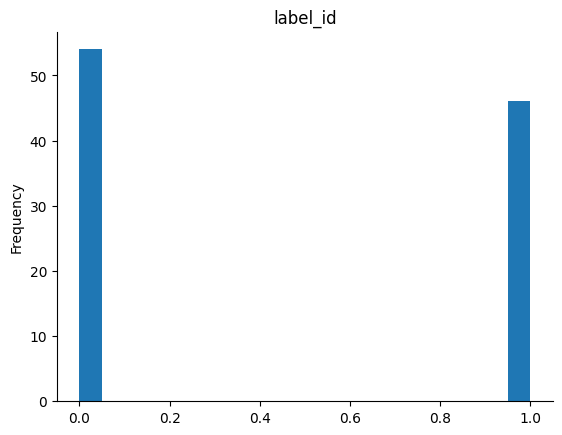

In [ ]:
val_data['label_id'].plot(kind='hist',bins=20)
plt.title('label_id')
plt.gca().spines[['top','right',]].set_visible(False)

چاپ توزیع برچسب های داده اموزش

In [ ]:
train_data['label_id'].value_counts()

,count
label_id,
0.0,513
1.0,487


چاپ توزیع برچسب های داده اعتبارسنجی

In [ ]:
val_data['label_id'].value_counts()

,count
label_id,
0.0,54
1.0,46


#آماده سازی داده ها

In [ ]:
tokenizer= AutoTokenizer.from_pretrained("HooshvareLab/albert-fa-zwnj-base-v2")
#یکی از مدل های خانواده برت رو به عنوان پارامتر بهش پاس دادیم
# ما توی زبان فارسی پارس برت رو داریم فابرت داریم توکا برت داریم ال برت داریم
#ال برت یکم جمع و جور تره

#pretrain= یعنی اینکه این مدل از قبل با ی حجم قابل توجه ای اموزش دیده و مدل اموزش دیده در اختیار ماست


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/857k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

In [ ]:
train_tokens= tokenizer(list(train_data['comment']),padding=True,truncation=True)

val_tokens= tokenizer(list(val_data['comment']),padding=True,truncation=True)

#padding=طول جمله ها متفاوته این پدینگ میاد طول اون جمله هارو پد بهش اضافه میکنه تا به محدوده ظرفیت بردار مدل مد نظرمون برسه وطول همه برابر باشند

#truncation=هر مدل ظرفیتی داره برای توکن سازی اگر از اون ظرفیت بیشتر باشه اونو کات میکنه

In [ ]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(train_tokens['input_ids'][0])       #عدد هر توکن در بردار معنایی
print(train_tokens['attention_mask'][0])  #در واقع این داره میگه به کدوم از توکن ها توجه داشته باش به کدوم ها نداشته باش همونطور که میبینیم تا سپریتور 1 و بقیش 0 ینی مهم نیست توجه نکن و فقط به 1 توجه کن
print(tokenizer.decode(train_tokens['input_ids'][0])) #اینجا اولین نمونه ای که داشتیم توکن هاشو چاپ کردیم

#cls=مفهوم تمام جمله
# اینجا به ازای کلمه است ما اینپوت ایدی 1151 رو داریم
# به ازای سی‌ال‌اس هم اینپوت ایدی دو
#همونظور که مشاهده میشه طول جمله کمتر از اون ظرفیته و به بقیش پد اضافه کرده


[2, 1151, 387, 1757, 155, 130, 1150, 790, 736, 204, 387, 345, 137, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

#ایجاد دیتاست برای اموزش مدل

In [ ]:
#ارث‌ بری از دیتاست
class TokenData(Dataset):
    def __init__(self,train=False):
      if train:
          self.text_data=train_data['comment']
          self.tokens=train_tokens
          self.labels=list(train_data['label_id'])

      else:
        self.text_data=val_data['comment']
        self.tokens=val_tokens
        self.label=list(val_data['label_id'])

    def __len__(self):
      return len(self.text_data)


    def __getitem__(self,index):
      sampel={}
      for key,value in self.tokens.items():
        sampel[key] = torch.tensor(value[index])

      sampel['label']= torch.tensor(self.labels[index])

      return sampel

In [ ]:
batch_size=40

train_dataset= TokenData(train=True)
train_loader= DataLoader(train_dataset, shuffle=True ,batch_size=batch_size)


val_dataset= TokenData(train=False)
val_loader= DataLoader(val_dataset, shuffle=True, batch_size=batch_size)

In [ ]:
len(train_dataset)

1000

In [ ]:
train_dataset[1]

{'input_ids': tensor([   2, 7015, 7209,  210,  136,  283,  160, 2924,  209, 4360,  310,  264,
            3,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [ ]:
train_iter= iter(train_loader)
sampel= next(train_iter)
print(sampel.items())

dict_items([('input_ids', tensor([[    2,   130,  1500,  ...,     0,     0,     0],
        [    2,  2835,   763,  ...,     0,     0,     0],
        [    2,   763,   117,  ...,     0,     0,     0],
        ...,
        [    2,   574,  3752,  ...,     0,     0,     0],
        [    2, 14281,   141,  ...,     0,     0,     0],
        [    2,  1369,   505,  ...,     0,     0,     0]])), ('token_type_ids', tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])), ('attention_mask', tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])), ('label', tensor([0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 0., 0., 0., 1.

#تعریف مدل

In [ ]:
bert_model=BertForSequenceClassification.from_pretrained('HooshvareLab/albert-fa-zwnj-base-v2')

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/44.9M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/albert-fa-zwnj-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.o

تعریف بهینه ساز

In [ ]:
optimizer= Adam(bert_model.parameters(),lr=1e-5)

تعریف تابع خطا

In [ ]:
loss_function=torch.nn.CrossEntropyLoss()

تعیین تعداد ایپاک و دیوایس

In [ ]:
num_epochs=3
device= 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [ ]:
bert_model.to(device)   #Tranfer model to GPU if available

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

#تعریف لوپ آموزش مدل

In [ ]:
for epoch in range(num_epochs):
  print(f"epoch: {epoch + 1}")
  #training  Block starts
  #set the model to train
  bert_model.train()
  for i , batch in enumerate(train_loader):
    batch= {k: v.to(device) for k , v in batch.items()}

  #setting the gradients to zero
    optimizer.zero_grad()

  #passing the data to the model
    outputs = bert_model(input_ids= batch['input_ids'], attention_mask= batch['attention_mask'])


  #the logits will be use for measuring the loss
    pred= outputs.logits
    loss= loss_function(pred, batch['label'])

  # calculating the gradiant for the loss function
    loss.backward()

  #optimizing the parameters of the bert model
    optimizer.step()

  #calculating the runing loss for logging purposes
    train_batch_loss= loss.item()
    train_last_loss= train_batch_loss / batch_size

    print('training batch {} last loss {}'.format(i+1,train_last_loss))

#logging epoch-wise training loss
print(f"\nTraining epoch {epoch + 1} loss:", train_last_loss)

#training block ends


#testing block start
bert_model.eval()
correct = 0
val_pred= []
for i , batch in enumerate(val_loader):
    batch= {k: v.to(device) for k , v in batch.items()}

    #we dont need gradiand for testing
    with torch.no_grad():
      outputs= bert_model(input_ids= batch['input_ids'],attention_mask= batch['attention_mask'])

    #logits act as prediction
    logits= outputs.logits

    #calculating total batch loss useing the logits and labels
    loss= loss_function(logits,batch['label'])
    val_batch_loss=loss.item()


    #calculating the mean batch loss
    val_last_loss = val_batch_loss / batch_size
    print('testing batch {} loss: {}'.format(i+1,val_last_loss))

    #comparing the predict target with the labels in the batch
    correct+= (logits.argmax(1)== batch['label']).sum().item()
    print("validation accuracy :",correct/((i+1)* batch_size))

print(f"\nValidation epoch {epoch+1} last_loss", val_last_loss)
#testing block ends

epoch: 1


RuntimeError: expected scalar type Long but found Float

In [ ]:
print('validation accuracy: ', correct/len(val_data[:100]))

NameError: name 'correct' is not defined

#ذخیره مدل

In [ ]:
torch.save(bert_model.state_dict(),'./model.pt')

#ارزیابی مدل اموزش داده شده

In [ ]:
test_data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Snapfood/test.csv',
                  encoding='utf8',on_bad_lines='skip',delimiter=',',index_col=False)

In [ ]:
test_data= test_data[:200]

In [ ]:
test_data_tokens= tokenizer(list(test_data['comment']),padding=True,truncation=True)
len(test_data_tokens['input_ids'])

200

In [ ]:
class TestData(Dataset):
    def __init__(self):
          self.text_data=test_data['comment']
          self.tokens=test_data_tokens
    def __len__(self):
      return len(self.text_data)

    def __getitem__(self,index):
      sampel={}
      for key,value in self.tokens.items():
        sampel[key] = torch.tensor(value[index])

      return sampel

In [ ]:
test_data_dataset= TestData()
test_data_loader=DataLoader(test_data_dataset,batch_size=20)

In [ ]:
weights= torch.load('./model.pt')
bert_model.load_state_dict(weights)
bert_model.to(device)

<ipython-input-33-81e5124c0ce0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights= torch.load('./model.pt')


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
bert_model.eval()
result= []
for i, batch in enumerate(test_data_loader):
  batch= {k: v.to(device) for k , v in batch.items()}
  with torch.no_grad():
    outputs= bert_model(input_ids= batch['input_ids'],attention_mask= batch['attention_mask'])

  logits= outputs.logits
  result.extend(list(torch.nn.functional.softmax(logits, dim= 1).type(torch.float)))

result=[i[1].item() for i in result]

In [ ]:
result_df = pd.DataFrame()
result_df['label_id'] = test_data['label_id']
result_df['probability']= [1 if res > 0.5 else 0 for res in result]

In [ ]:
result_df.to_csv('./submission1.csv', index= False)

In [ ]:
result_df

,label_id,probability
0,0.0,1
1,0.0,1
2,1.0,1
3,1.0,1
4,1.0,1
...,...,...
195,0.0,1
196,0.0,1
197,1.0,1
198,1.0,1


دقت تشخیصمون:

In [ ]:
(result_df['label_id'] == result_df['probability']).sum() / len(test_data)

0.59